In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210409\analysis_day0').resolve()
## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210409\suite2p\plane0').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import *

In [5]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [6]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [7]:
dFoF_params = pickle_helpers.simple_load(path_tqm)['dFoF_params']

In [8]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [9]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [10]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [11]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(F_toUse,
                                             kernel=kernel_smoothing,
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_smooth + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
# Threshold for nonnegativity
dFoF[dFoF<0]=0

ThreadPool elapsed time : 0.24 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.43 seconds
Calculated dFoF. Total elapsed time: 6.48 seconds


# Run NMF

In [12]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)

In [13]:
tl.set_backend('pytorch')

In [14]:
neural_data_toUse = tl.tensor(neural_data_toUse).to('cuda')

In [15]:
# Roll a dice and wish for luck
rank = 10

In [16]:
factors_nmf = tl.decomposition.non_negative_parafac(
            neural_data_toUse,
            rank=rank,
            n_iter_max=500,
            init='random',
            svd='numpy_svd', 
            tol=1e-06,
        #     random_state=None,
            verbose=0,
        #     normalize_factors=False,
        #     return_errors=False,
        #     mask=None,
        #     cvg_criterion='abs_rec_error',
        #     fixed_modes=None
        )

In [17]:
factors_temporal_nmf = np.array(factors_nmf.factors[1].to('cpu')).T

In [18]:
# nmf = sklearn.decomposition.NMF(
#     n_components=10, 
#     init='warn',
#     solver='cd',
#     beta_loss='frobenius',
#     tol=0.0001,
#     max_iter=500, 
#     random_state=None,
#     alpha='deprecated',
#     alpha_W=0.0,
#     alpha_H='same',
#     l1_ratio=0.0,
#     verbose=0,
#     shuffle=False, 
#     regularization='deprecated'
# )
# factors_neurons_nmf = nmf.fit_transform(neural_data_toUse)
# factors_temporal_nmf = nmf.components_

# Run Regression
Regress z-scored NMF temporal factors onto z-scored neural data itself

In [19]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score NMF outputs
factors_temporal_nmf_zscore = scipy.stats.zscore(factors_temporal_nmf[:,indices_to_use],axis=1)
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse.to('cpu')).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|████████████████████████████████████████████████████████████████████████| 108000/108000 [00:22<00:00, 4785.07it/s]
D:\RH_local\github\basic_neural_processing_modules\welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


In [20]:
## Elastic Net Regression
# regression = sklearn.linear_model.ElasticNet(
#     alpha=1.0, 
#     l1_ratio=0.5,
#     fit_intercept=True,
#     normalize='deprecated', 
#     precompute=False,
#     max_iter=1000, 
#     copy_X=True,
#     tol=0.0001,
#     warm_start=False,
#     positive=False,
#     random_state=None, 
#     selection='cyclic'
# )
# regression.fit(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)
# factors_temporal_regression = regression.predict(neural_data_toUse_zscore.T).T

In [21]:
# OLS Regression
theta, factors_temporal_regression = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)
factors_temporal_regression = factors_temporal_regression.T

In [22]:
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T, factors_temporal_nmf_zscore.T)
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]

# Run Orthogonalization

In [23]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

In [24]:
def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [25]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = factors_temporal_tokeep.shape[0]
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 5 index explains 0.04809880256652832 of the variance in neural data
Factor at 1 index explains 0.02327662706375122 of the variance in neural data
Factor at 4 index explains 0.018547415733337402 of the variance in neural data
Factor at 9 index explains 0.018100619316101074 of the variance in neural data
Factor at 7 index explains 0.011066973209381104 of the variance in neural data
Factor at 6 index explains 0.01050800085067749 of the variance in neural data
Factor at 0 index explains 0.009763002395629883 of the variance in neural data
Factor at 2 index explains 0.007271170616149902 of the variance in neural data
Factor at 3 index explains 0.0052738189697265625 of the variance in neural data


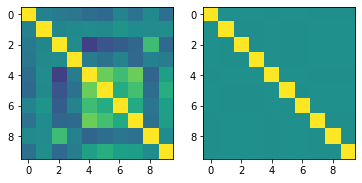

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

In [27]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [28]:
evrs

array([0.009763  , 0.02327663, 0.00727117, 0.00527382, 0.01854742,
       0.0480988 , 0.010508  , 0.01106697, 0.00346363, 0.01810062])

# Run Regression Pt 2

In [29]:
## Elastic Net Regression
# regression = sklearn.linear_model.ElasticNet(
#     alpha=0.01, 
#     l1_ratio=0.01,
#     fit_intercept=True,
#     normalize='deprecated', 
#     precompute=False,
#     max_iter=1000, 
#     copy_X=True,
#     tol=0.0001,
#     warm_start=False,
#     positive=False,
#     random_state=None, 
#     selection='cyclic'
# )
# regression.fit(neural_data_toUse_zscore.T, factors_orth.T)
# factors_spread_regression = regression.predict(neural_data_toUse_zscore.T).T

In [30]:
# OLS Regression
theta, factors_orth_regression = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_orth_regression.T, factors_orth.T)
#factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold

In [31]:
## Ridge regression

theta, y_rec = linear_regression.Ridge(
    neural_data_toUse_zscore.T, factors_orth.T,
    lam=100000000
)

# Cross Validated Regression

In [32]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [33]:
cv_idx = cross_validation.group_split(
    n_splits=4,
    n_samples=neural_data_toUse_zscore.shape[1],
    group_size=2*60*30, 
    test_size=0.3
)

In [34]:
parameters = {'alpha':[0.001], 'l1_ratio':[0]}
eln = sklearn.linear_model.ElasticNet(
    fit_intercept=True,
    normalize='deprecated', 
    precompute=False,
    max_iter=1000, 
    copy_X=True,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None, 
    selection='cyclic'
)
kf = KFold(n_splits=5)
kf.get_n_splits(neural_data_toUse_zscore)
clf = GridSearchCV(eln, parameters,cv=kf)

In [ ]:
clf.fit(neural_data_toUse_zscore.T, factors_orth.T)

C:\Users\Rich Hakim\.conda\envs\BMI_IDAP\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.976e+00, tolerance: 2.221e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [39]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.208310,0.433799,0.006390,0.000497,0.1,0.1,"{'alpha': 0.1, 'l1_ratio': 0.1}",0.923747,0.931954,0.904245,0.932534,0.938822,0.926260,0.012005,1
1,0.868565,0.010944,0.006188,0.000398,0.1,1,"{'alpha': 0.1, 'l1_ratio': 1}",0.558657,0.630906,0.563377,0.615106,0.661860,0.605981,0.039703,2
2,0.745048,0.018016,0.006198,0.000392,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",0.350366,0.393797,0.347778,0.415241,0.437540,0.388944,0.035382,3
3,0.461036,0.014659,0.006586,0.000492,1,1,"{'alpha': 1, 'l1_ratio': 1}",-0.068032,-0.075072,-0.049427,-0.003061,-0.002765,-0.039671,0.031161,4


In [ ]:
## NMF on training
factors_all = []
for i_rank, rank in enumerate(range(2,8)):
    factors_cv = []
    for cv in cv_idx:
        ## z-score NMF outputs
        factors_temporal_nmf_zscore = scipy.stats.zscore(factors,axis=1)
        theta, factor_preds = linear_regression.OLS(neural_data_for_regression[:,cv[0]], factors_temporal_nmf_zscore)
        test_preds = np.dot(theta, neural_data_for_regression[:,cv[1]])
        similarity.orthogonalize(test_preds, neural_data_for_regression[:,cv[1]])
        factors_cv.append(factors)
    factors_all.append(factors_cv)
    
## regression model on training

## EV on test

<IPython.core.display.Javascript object>


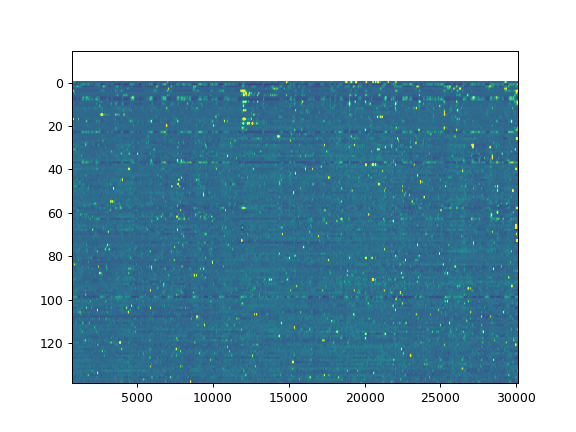

In [51]:
plt.figure()
plt.imshow(neural_data_toUse_zscore, aspect='auto', vmax=4)

<IPython.core.display.Javascript object>


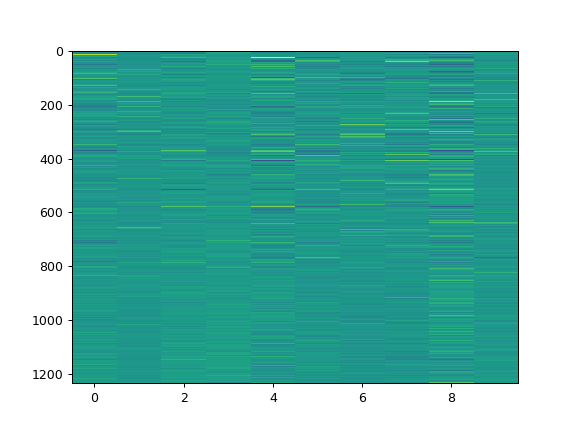

In [33]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

<IPython.core.display.Javascript object>


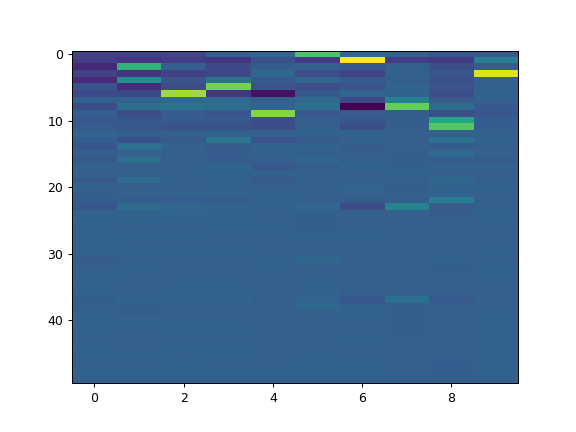

In [46]:
%matplotlib notebook
plt.figure()
plt.imshow(regression.coef_.T[:50,:],aspect='auto')

# Save it all

In [172]:
factor_to_use = 0
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights[:,factor_to_use],
    "weights_all" : weights,
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

In [23]:
## PCA
pca = sklearn.decomposition.PCA(
    n_components=None,
    copy=True, 
    whiten=False, 
    svd_solver='auto',
    tol=0.0, 
    iterated_power='auto',
    random_state=None
)
comp = pca.fit_transform(scipy.stats.zscore(factors_temporal_tokeep,axis =1).T).T

In [41]:
factors_temporal_tokeep.shape

(10, 90000)

In [43]:
np.sort(evrs)

array([0.00346363, 0.00527382, 0.00727117, 0.009763  , 0.010508  ,
       0.01106697, 0.01810062, 0.01854742, 0.02327663, 0.0480988 ])

<IPython.core.display.Javascript object>


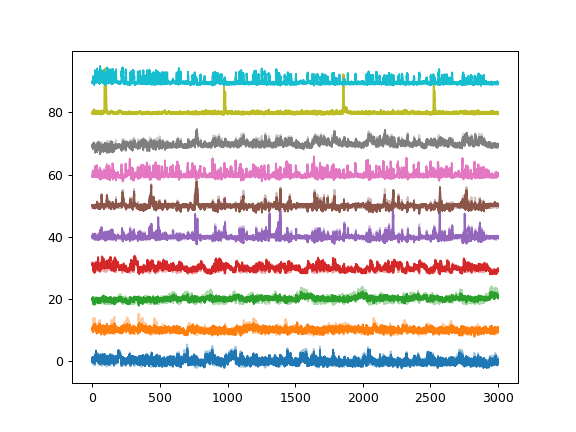

In [45]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs),:].T + 10*np.arange(10),alpha=0.4)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs),:].T + 10*np.arange(10))

# Figure out the number of factors
Method idea is to do cross validation and somehow use the predicted nmf factors on the test set to evaluate the model performance. Tough to say how

In [ ]:
## CV
num_minutes = 10
indices_for_regression = np.arange(int(Fs*60*num_minutes),neural_data_toUse.shape[1])
neural_data_for_regression = welford_moving_2D.make_rollingZScore(neural_data_toUse.T, win_roll=int(Fs*60*num_minutes)).T[:,indices_for_regression]
neural_data_for_nmf = neural_data_toUse[:,indices_for_regression]
cv_idx = cross_validation.group_split(
    n_splits=4,
    n_samples=neural_data_for_nmf.shape[1],
    group_size=2*60*30, 
    test_size=0.3
)
X_train = [ ]
X_test  = [neural_data_for_nmf[:,cv[1]] for cv in cv_idx]

## NMF on training
factors_all = []
for i_rank, rank in enumerate(range(2,8)):
    factors_cv = []
    for cv in cv_idx:
        factors = tl.decomposition.non_negative_parafac(
                    tl.tensor(neural_data_for_nmf[:,cv[0]]).to('cuda'),
                    rank=rank,
                    n_iter_max=500,
                    init='random',
                    svd='numpy_svd', 
                    tol=1e-06,
                #     random_state=None,
                    verbose=0,
                #     normalize_factors=False,
                #     return_errors=False,
                #     mask=None,
                #     cvg_criterion='abs_rec_error',
                #     fixed_modes=None
                )
        
        
        ## z-score NMF outputs
        factors_temporal_nmf_zscore = scipy.stats.zscore(factors,axis=1)
        theta, factor_preds = linear_regression.OLS(neural_data_for_regression[:,cv[0]], factors_temporal_nmf_zscore)
        test_preds = np.dot(theta, neural_data_for_regression[:,cv[1]])
        similarity.orthogonalize(test_preds, neural_data_for_regression[:,cv[1]])
        factors_cv.append(factors)
    factors_all.append(factors_cv)
    
## regression model on training

## EV on test

In [ ]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return dot(Phi, R)

In [102]:
X = neural_data_toUse_zscore.T
y = factors_orth.T

In [103]:
X.shape
# y.shape

(36000, 679)

<IPython.core.display.Javascript object>


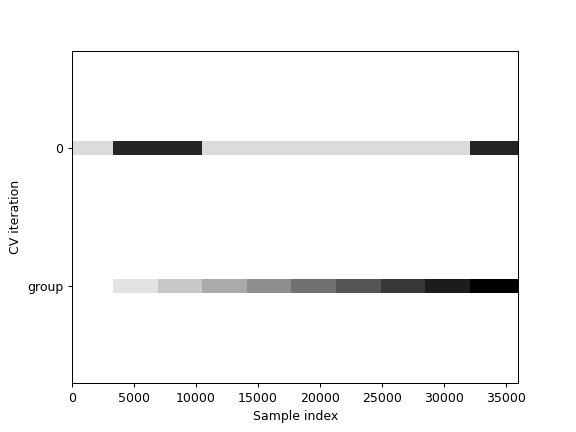

computed y #: 0
computed y #: 1
computed y #: 2
computed y #: 3
computed y #: 4
computed y #: 5
computed y #: 6
computed y #: 7
computed y #: 8


In [104]:
from basic_neural_processing_modules import cross_validation
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                StratifiedKFold, GroupShuffleSplit,
                                GroupKFold, StratifiedShuffleSplit)
group_len = 60*2 * Fs # seconds * Fs
n_splits = 1
test_size = 0.3
groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx = cross_validation.make_cv_indices(cv,
                                        groups,
                                        lw=10,
                                        plot_pref=True)
    
n_nonzero_rolls = 0
min_roll = 60*1*Fs
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_nonzero_rolls)))
n_rolls = n_nonzero_rolls + 1
# model_params_cuml_ElasticNet = {
#         'fit_intercept': True,
#         'normalize': False,
#         'max_iter': 1000,
#         'tol': 0.0001,
#         'selection': 'cyclic',
# }

model_params_sklearn_ElasticNet = {
    'fit_intercept': True,
#     'normalize': 'deprecated', 
#     'precompute': False,
#     'max_iter': 1000, 
#     'copy_X': True,
#     'tol': 0.0001,
#     'warm_start': False,
#     'positive': False,
#     'random_state': None, 
#     'selection': 'cyclic'
}

model_params_sklearn_Ridge = {
#     'alpha': 1.0,
}

# l1_ratios = np.array([0, 0.01, 0.1, 0.5, 0.9, 0.99, 1])
l1_ratios = np.array([0])
# alphas = np.array([0.0001, 0.001, 0.01, 0.1])
alphas = np.array([1, 100, 10000, 10000000])

# prepare output variables for in-place computations
n_y = y.shape[1]
n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)
theta = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios, X.shape[1]))
intercept = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_train  = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_test   = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))
# Run regression sweep
theta, intercept, EV_train, EV_test, preds = linear_regression.LinearRegression_sweep(   X,
                                                                y,
                                                                cv_idx,
                                                                alphas=alphas,
                                                                l1_ratios=l1_ratios,
                                                                rolls=rolls,
                                                                method_package='sklearn',
                                                                method_model='Ridge',
                                                                compute_preds=True,
                                                                verbose=True,
                                                                theta_inPlace=theta, 
                                                                intercept_inPlace=intercept,
                                                                EV_train_inPlace=EV_train,
                                                                EV_test_inPlace=EV_test,
                                                                **model_params_sklearn_Ridge
                                                                )

In [105]:
theta.shape

(9, 1, 1, 4, 1, 679)

<IPython.core.display.Javascript object>


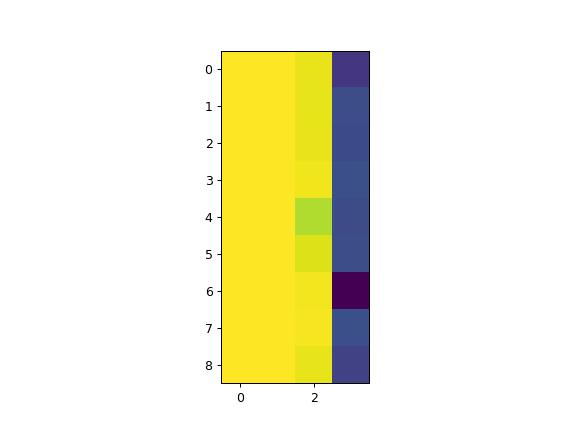

In [114]:
EV_test.shape
plt.figure()
plt.imshow(EV_test.squeeze())

<IPython.core.display.Javascript object>


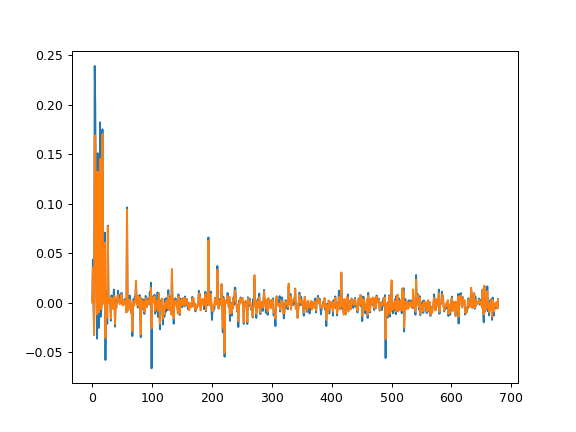

In [116]:
plt.figure()
plt.plot(theta.squeeze()[0,0,:])
plt.plot(theta.squeeze()[0,2,:])

<IPython.core.display.Javascript object>


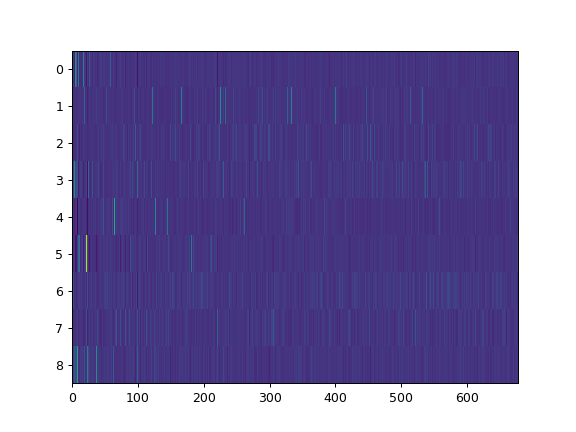

In [109]:
%matplotlib notebook
plt.figure()
plt.imshow(theta.squeeze()[:,0,:],aspect='auto', interpolation='none')
# plt.imshow(np.diff(theta.squeeze(), axis=1)[:,1,:100],aspect='auto', interpolation='none')

<IPython.core.display.Javascript object>


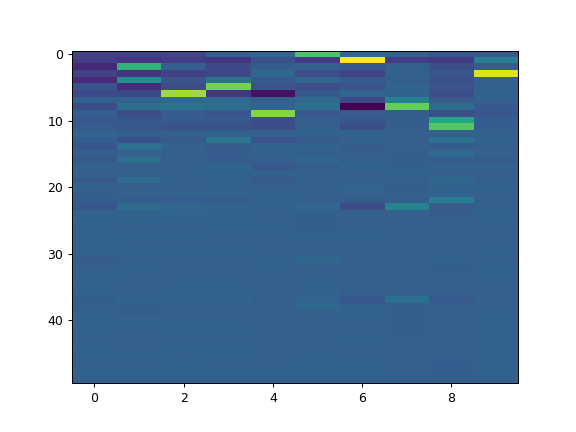

In [46]:
%matplotlib notebook
plt.figure()
plt.imshow(regression.coef_.T[:50,:],aspect='auto')

<IPython.core.display.Javascript object>


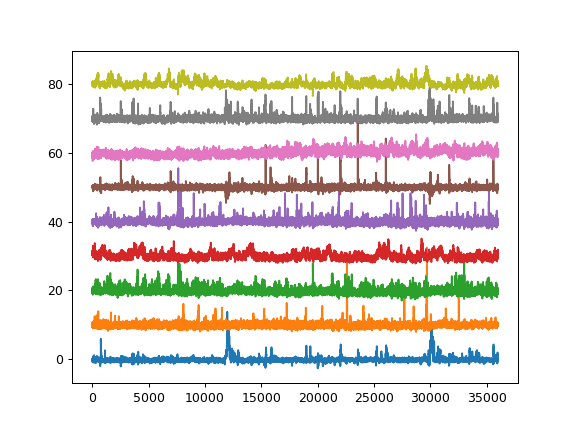

In [120]:
plt.figure()
plt.plot(preds.squeeze()[:,0,:].T + 10*np.arange(9))

In [117]:
preds.shape

(9, 1, 1, 4, 1, 1, 36000)